
# Headers



In [1]:
%matplotlib inline
import cobra
import PyDSTool as dst
import pandas as pd
import matplotlib.pyplot as plt
import copy
import sys
import pdb


# Utility Functions



In [55]:
# Functions for initialization

def cleanupname(name):
    """
     The reaction names in the model files 
     don't have brackets or parentheses. I replaced
     those found in the mediaFluxes file.
     """
    name = name.replace('[', '_LPAREN_')
    name = name.replace(']', '_RPAREN_')
    name = name.replace('(', '_LPAREN_')
    name = name.replace(')', '_RPAREN_')
    return name

def defineDFBAModel(SpeciesDict , MediaDF):
    print("Defining Dynamical model... \n")
    ParDef = dict()
    VarDef = dict()
    ICS = dict()
    exchange_list = []
    mediaDerivedComponents = {}
    for i, row in MediaDF.iterrows():
        N = cleanupname(row.Reaction)
        mediaDerivedComponents[N] = row['Flux Value'] / (24.0*60.0) # Per minute

    for species in SpeciesDict.keys():
        SpeciesDict[species]['SpeciesModel'] = cobra.io.read_sbml_model(SpeciesDict[species]['File'])
        SpeciesDict[species]['OriginalLB'] = {r.id:r.lower_bound for r in SpeciesDict[species]['SpeciesModel'].exchanges}
        SpeciesDict[species]['solution'] = SpeciesDict[species]['SpeciesModel'].optimize()
        SpeciesDict[species]['Name'] = SpeciesDict[species]['SpeciesModel'].name.split(' ')[0]
        exchange_list += SpeciesDict[species]['SpeciesModel'].exchanges
        Name=SpeciesDict[species]['Name']
        ParDef['mu' + '_' + Name] = SpeciesDict[species]['solution'].objective_value/60
        VarDef[Name] =  'mu_' + Name + ' * ' + Name ### Biomass
        ICS[Name] = 1e-2

    all_exchanges = set()

    for ex in exchange_list:
        all_exchanges.add(ex.id)
        #     all_exchanges = list(set(exchange_list))

    for rid in all_exchanges:
        VarDef[rid] = '0'
        ICS[rid] = 1

        if rid in mediaDerivedComponents.keys():
            ParDef[rid + '_influx'] = mediaDerivedComponents[rid]
            VarDef[rid] += ' + ' +  rid + '_influx'

        for species in SpeciesDict.keys():
            # print(SpeciesDict[species]['Name'])
            if 'h2o' in rid:
                print(species, rid)
            if rid in [species_r.id for species_r in SpeciesDict[species]['SpeciesModel'].exchanges]:
                Name = SpeciesDict[species]['Name']
                ParDef[rid + '_' + Name] = SpeciesDict[species]['solution'].fluxes[rid]/60.0
                VarDef[rid] += ' + ' +  rid + '_' + Name + ' * ' + Name

    ModelDef = dst.args(name='Community',
                    pars=ParDef,
                        varspecs=VarDef,
                        ics=ICS)
    ModelDS = dst.Vode_ODEsystem(ModelDef)
    print("Done!")
    return (SpeciesDict, ModelDef, ModelDS)

# Functions for model updates

def recomputeLowerBounds(SpeciesDict, PrevSteadyState, Kmax):
    for species in SpeciesDict.keys():
        for rid in [rxn.id for rxn in SpeciesDict[species]['SpeciesModel'].exchanges]:
            SpeciesDict[species]['SpeciesModel'].reactions.get_by_id(rid) \
                                                   .lower_bound = \
                                                                  SpeciesDict[species]['OriginalLB'][rid] \
                                                                  * PrevSteadyState[rid]/(Kmax+PrevSteadyState[rid])
    return SpeciesDict

def updateFluxParameters(SpeciesDict, ModelDS, PrevSteadyState):
    ParDef = {}
    ICS = {}
    for species in SpeciesDict:
        solution = SpeciesDict[species]['SpeciesModel'].optimize()
        Name = SpeciesDict[species]['Name']
        ParDef['mu_' + Name] = solution.objective_value/60.0
        ICS[Name] = PrevSteadyState[Name]
        exchanges = [r.id for r in SpeciesDict[species]['SpeciesModel'].exchanges]
        for rid in exchanges:
            ParDef[rid + '_' + Name] = solution.fluxes[rid]/60.0
            ICS[rid] = PrevSteadyState[rid]
    ModelDS.set(pars=ParDef, ics=ICS)
    return ModelDS

def update(SpeciesDict, ModelDS, PrevSteadyState, Kmax):
    UpdatedSpeciesDict = recomputeLowerBounds(SpeciesDict,
                                              PrevSteadyState, Kmax)

    UpdatedDynamicModel = updateFluxParameters(UpdatedSpeciesDict,
                                               ModelDS,
                                               PrevSteadyState)
    # P = simulateModel(updatedDynamicalModel)
    return(UpdatedSpeciesDict, UpdatedDynamicModel)

def get_ss(PointSet):
    SSPoints={}
    for k in PointSet.keys():
        if len(PointSet[k]) == 0:
             SSPoints[k]= 0 #PointSet[k][-1]
        else:
             SSPoints[k]=PointSet[k][-1]
    return(SSPoints)

def checkNegativeMetabolites(PointSet,StoreNegatives):
    IndexStop = len(PointSet['EX_h2o_LPAREN_e_RPAREN_']) - 1

    for variable in PointSet.keys():
        if PointSet[variable][-1] < 0.0: # checking only final Tpoint, b/c monotonic
            varIndex = next((index for index,value in enumerate(PointSet[variable]) if value < 0), None)
            if varIndex < IndexStop:
                # Update the index for the first negative crossing
                IndexStop = varIndex

    if IndexStop < len(PointSet['EX_h2o_LPAREN_e_RPAREN_']) - 1 and IndexStop > 0:
        P_tilFirstNeg={}
        for variable in PointSet.keys():
            P_tilFirstNeg[variable]=P[variable][:IndexStop]
            if PointSet[variable][IndexStop] < 0:
                P_tilFirstNeg[variable][-1] = 0
                StoreNegatives.add(variable)
        P_tilFirstNeg['t'] = PointSet['t'][:IndexStop]
        PointSet = P_tilFirstNeg
    return(PointSet,StoreNegatives)


# Test:



In [56]:
SpeciesDict = {'Sp1': {'File':'./data/Bacteroides_sp_1_1_14.xml'},
               'Sp2': {'File':'./data/Actinomyces_urogenitalis_DSM_15434.xml'},
               'Sp3': {'File':'./data/Escherichia_coli_str_K_12_substr_MG1655.xml'}
}
MediaDF = pd.read_csv('./data/VMH_HighFiber.tsv', sep='\t')

SpeciesDict, Definition, ModelDS = defineDFBAModel(SpeciesDict, MediaDF)
InitialValues = {k:[v] for (k,v) in Definition.ics.items()}

Defining Dynamical model... 

Sp1 EX_h2o_LPAREN_e_RPAREN_
Sp3 EX_h2o_LPAREN_e_RPAREN_
Sp2 EX_h2o_LPAREN_e_RPAREN_
Done!


In [49]:
AllPoints = []
StoreNegatives = set()
P = InitialValues
T0=0
TEND = 800
TSPAN = 100
Kmax=0.5
IndexStop = len(P['EX_h2o_LPAREN_e_RPAREN_'])
i=0
MaxIter=18
TERMINATE = False
while T0 < TEND and i < MaxIter:
#and not TERMINATE:
    i+=1
    print(T0)
    SpeciesDict, ModelDS = update(SpeciesDict, ModelDS, get_ss(P), Kmax)

    if T0+TSPAN > TEND:
        TSPAN = TEND - T0

    ModelDS.set(tdata=[T0, T0 + TSPAN])
    P = ModelDS.compute('test').sample() 

    # Initialize
    P, StoreNegatives = checkNegativeMetabolites(P,StoreNegatives) 
    T0 = P['t'][-1]
#     if len(P['t']) != 0:
#         T0 = P['t'][-1]
#     else:
#         TERMINATE = True

    AllPoints.append(P)

0
100.0
200.0
300.0
400.0
500.0
553.1153115311531
609.2909290929093
615.9115911591159
621.1721172117212
625.6625662566257
630.03300330033
634.3234323432343
638.6138613861386
642.8842884288429
679.1079107910791
696.3896389638965
703.0803080308032


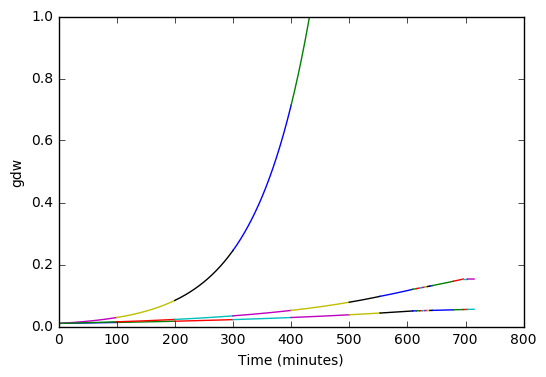

In [51]:

for sp in SpeciesDict.keys():
      for P in AllPoints:
#                  for k in P.keys():
          plt.plot(P['t'], P[SpeciesDict[sp]['Name']])
plt.xlabel('Time (minutes)')
plt.ylim([0,1])
plt.ylabel('gdw')

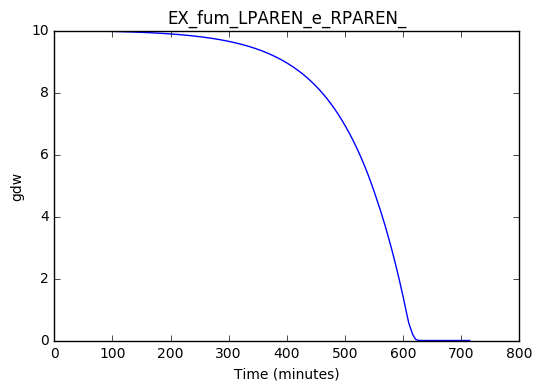

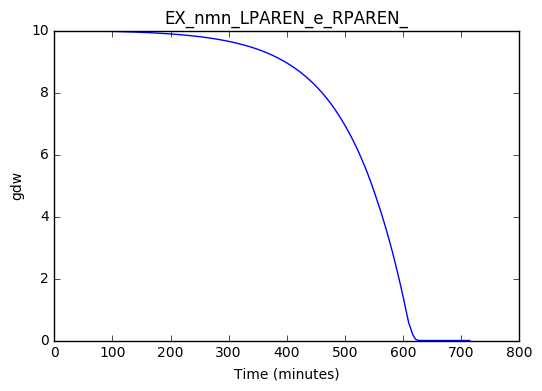

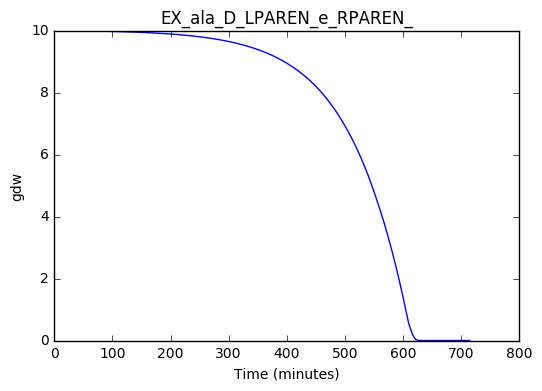

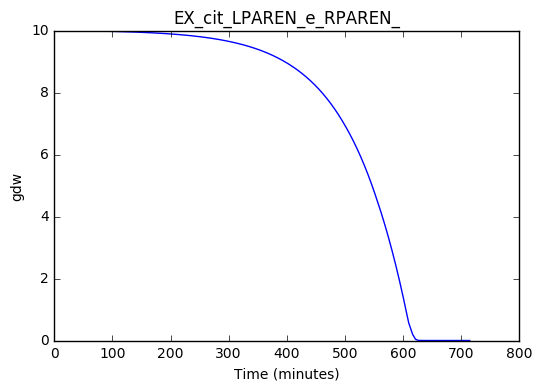

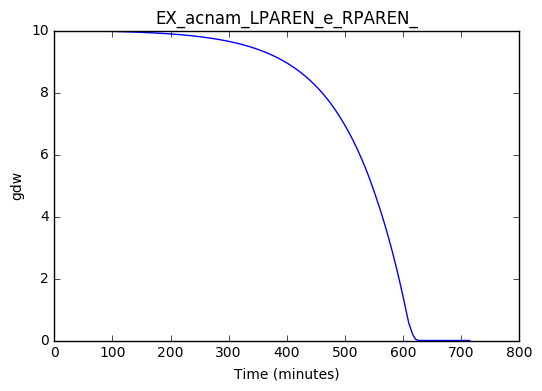

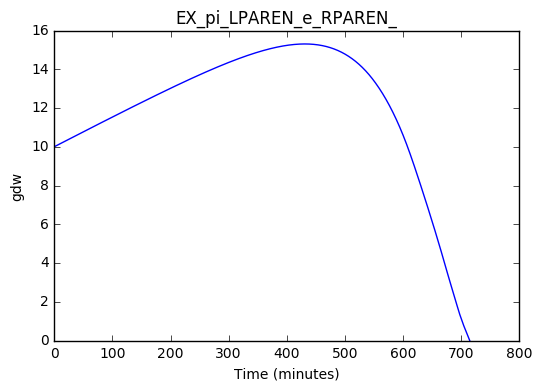

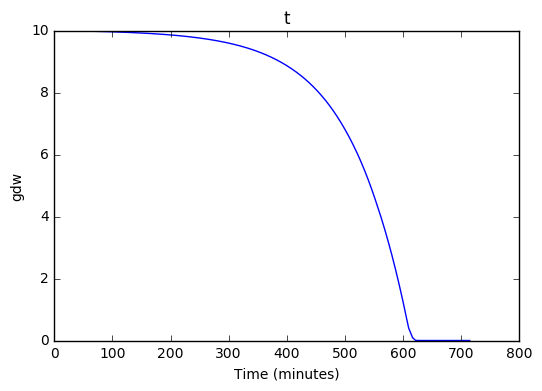

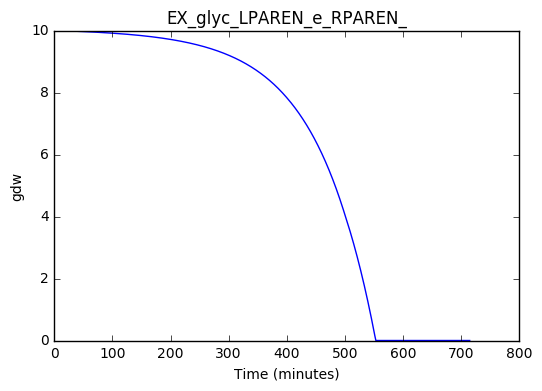

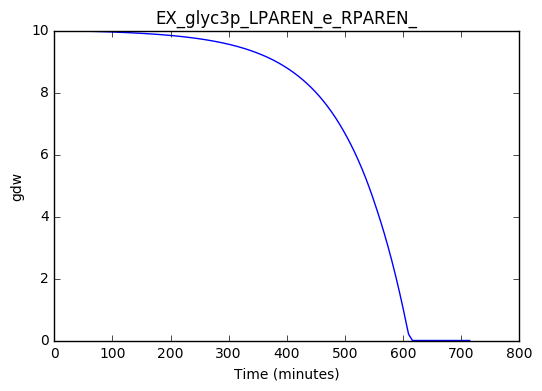

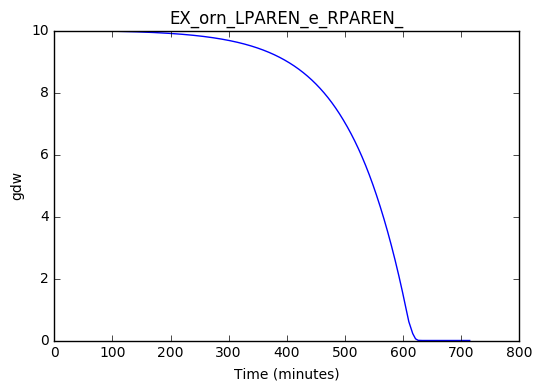

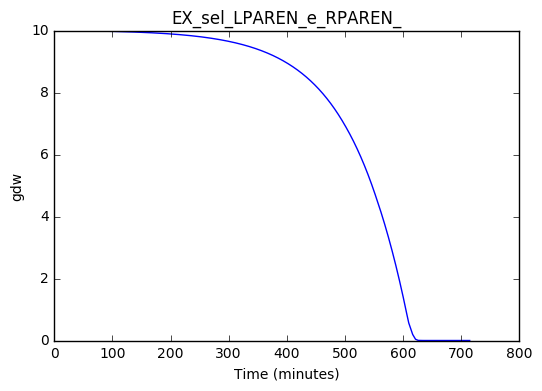

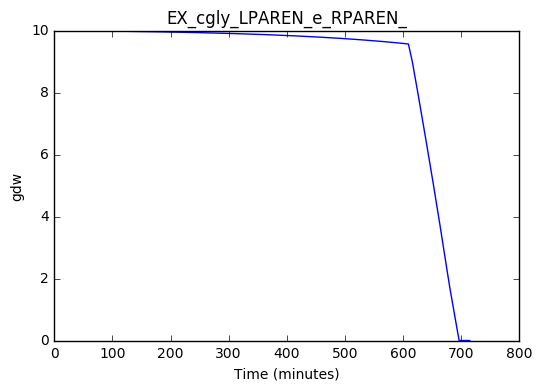

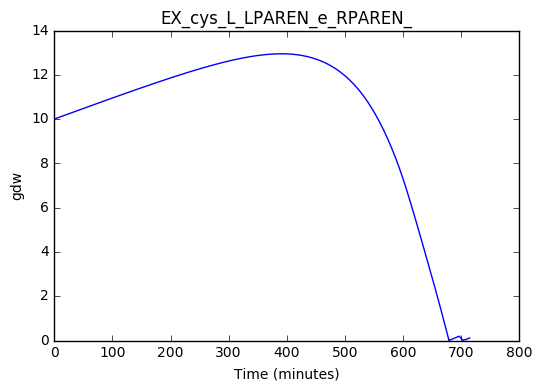

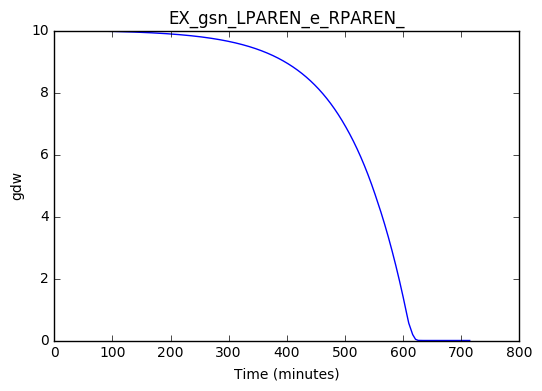

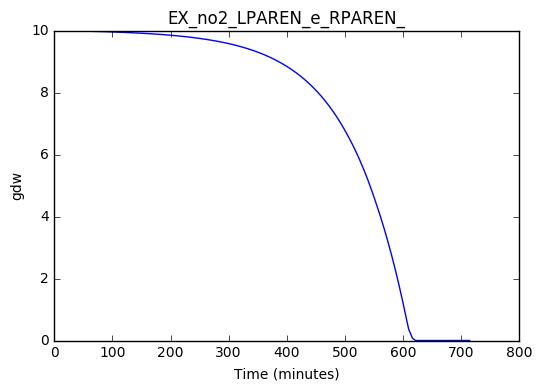

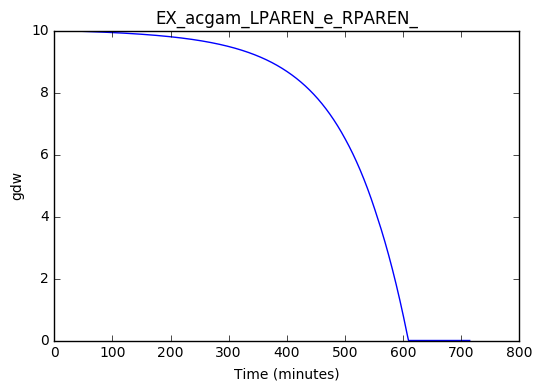

In [54]:
TimePoints={}
TimePoints['t'] =[]

for P in AllPoints:
    TimePoints['t'] += list(P['t'])
    
for variable in StoreNegatives:
    TimePoints[variable] = []
    for P in AllPoints:
        TimePoints[variable]+=list(P[variable])

for k in TimePoints.keys():
    if k != 't':
        plt.figure()
        plt.plot(TimePoints['t'], TimePoints[k])
    plt.title(k)    
    plt.xlabel('Time (minutes)')
    #plt.ylim([0,0.5])
    plt.ylabel('gdw')

(0.0, 1)

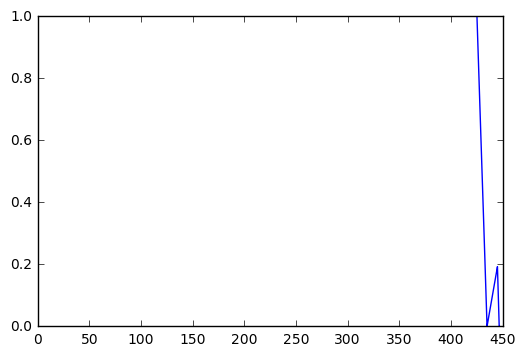

In [35]:
plt.plot(TimePoints['t'], TimePoints['EX_cys_L_LPAREN_e_RPAREN_'])
plt.ylim([0.0,1])